In [1]:
import time
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
np.random.seed(1729)

In [3]:
def simulate_data(N, P):
        
        # Simulating transmission and occurence rates
        transmission_rate = np.random.beta(2, 10, P)
        occurrence_rate = np.random.beta(2, 10, P)
        base_rate = np.random.beta(2, 10, 1)
        
        data = {}
        for p in range(P):
            occurrence = np.random.binomial(1, occurrence_rate[p], N)
            transmission = occurrence * np.random.binomial(1, transmission_rate[p], N)
            data[f'O{p+1}'] = occurrence
            data[f'T{p+1}'] = transmission
        
        data['T0'] = np.random.binomial(1, base_rate, N)
        X = pd.DataFrame(data)
        z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
        y = (z > 0).astype(int)
        X = X.loc[:, X.columns.str.startswith('O')]
        ground_truth = {'true_occurence_rate':occurrence_rate, 
                        'true_theta':transmission_rate, 
                        'true_rho':base_rate}
        data = {'N': N, 'P': P, 'X': X.to_numpy(), 'y': y.to_numpy()}
        return [ground_truth, data]

In [4]:
# Stan model code
model_code = """
data {
  int<lower=0> N;                            // number of observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
}
transformed parameters {
  // Precomputation
  real log1m_theta[P];
  real log1m_rho;
  
  for (p in 1:P) {
    log1m_theta[p] = log1m(theta[p]);
  }

  log1m_rho = log1m(rho);
}
model {
  // Priors
  theta ~ uniform(0, 1);
  rho ~ uniform(0, 1);
  
  // Likelihood
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    
    if (y[n] == 1) {
      target += log1m_exp(s);
    } 
    else {
      target += s;
    }
  }
}
""" 

In [5]:
def lineplot_N(N_space, P=4):
    """
    Plots model runtime as a function of the number of fitting samples
    Saves plot as .png file
    
    :param model: A Test and Trace model object
    :param N_space: One-dimensional iterable of integers for each number of fitting samples
    
    """ 
    N_space = np.sort(np.array(N_space))
    runtimes = []
    rmses = []
    rhats = []
    for i in N_space:
        N = int(i)
        print('Running model...')
        start = time.time()
        simulation = simulate_data(N,P)
        model_data = simulation[1]
        ground_truth = simulation[0]
        posterior = stan.build(model_code, data=model_data, random_seed=1)
        fit = posterior.sample(num_samples=1000, num_warmup=500, num_chains=4)
        end = time.time()
        print('Finished running')
        runtimes.append((end - start))
        stats = arviz.summary(fit, var_names=['the', 'rho'], filter_vars='like')
        stats = stats['r_hat']
        conv = (abs(1-stats)).max()
        rhats.append(conv)
        fit = fit.to_frame()
        desc_fit = fit.describe().T
        desc_fit = desc_fit['mean']
        error = np.mean((desc_fit.iloc[7:(P+7)] - ground_truth['true_theta']) ** 2)
        rmses.append(error**0.5)
    plots = {'times':runtimes, 'r_hats':rhats, 'errors':rmses}
    return plots

In [6]:
def lineplot_P(P_space, N=(10 ** 4),):
    """
    Plots model runtime as a function of the number of theta parameters
    Saves plot as .png file
    
    :param model: A Test and Trace model object
    :param N_space: One-dimensional iterable of integers for each number of fitting samples
    
    """ 
    P_space = np.sort(np.array(P_space))
    runtimes = []
    rmses = []
    rhats = []
    for i in P_space:
        P = int(i)
        print('Running model...')
        start = time.time()
        simulation = simulate_data(N,P)
        model_data = simulation[1]
        ground_truth = simulation[0]
        posterior = stan.build(model_code, data=model_data, random_seed=1)
        fit = posterior.sample(num_samples=1000, num_warmup=500, num_chains=4)
        end = time.time()
        print('Finished running')
        runtimes.append((end - start))
        stats = arviz.summary(fit, var_names=['the', 'rho'], filter_vars='like')
        stats = stats['r_hat']
        conv = (abs(1-stats)).max()
        rhats.append(conv)
        fit = fit.to_frame()
        desc_fit = fit.describe().T
        desc_fit = desc_fit['mean']
        error = np.mean((desc_fit.iloc[7:(P+7)] - ground_truth['true_theta']) ** 2)
        rmses.append(error**0.5)
    plots = {'times':runtimes, 'r_hats':rhats, 'errors':rmses}
    return plots

In [7]:
a = 10**3
Ns = [2*a, 4*a, 6*a, 8*a, 10*a, 12*a, 14*a, 16*a, 18*a, 20*a, 22*a, 24*a, 26*a, 28*a, 30*a, 32*a, 34*a, 36*a, 38*a, 40*a]
#FF = [3*a, 6*a, 9*a, 12*a, 15*a, 18*a, 21*a, 24*a, 27*a, 30*a, 33*a, 36*a]
Ps = [4,8,12,16,20,24,28,32,36,40]
data_N = lineplot_N(Ns, P=4)
data_P = lineplot_P(Ps)

Building...
Found model in cache. Done.
Sampling...


Running model...


    0/6000 [>---------------------------]   0%  1 sec/0     
  300/6000 [=>--------------------------]   5% 5 secs/87  Messages received during sampling:
  Gradient evaluation took 0.00033 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00033 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00033 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00033 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.3 seconds.
  Adjust your expectations accordingly!

 1500/6000 [=======>--------------------]  25% 5 secs/18    
 6000/6000 [============================] 100% 5 secs/5     
Done.


Finished running


Building...
Found model in cache. Done.
Sampling...


Running model...


    0/6000 [>---------------------------]   0%  1 sec/0     
  200/6000 [>---------------------------]   3%  1 sec/31    
  300/6000 [=>--------------------------]   5% 8 secs/145 Messages received during sampling:
  Gradient evaluation took 0.000353 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000353 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000353 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000353 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.53 seconds.
  Adjust your expectations accordingly!

 1500/6000 [=======>--------------------]  25% 8 secs/30    
 6000/6000 [============================] 100% 8 secs/7

Finished running


Building...


Running model...


Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
  100/6000 [>---------------------------]   1%  1 sec/62    
  300/6000 [=>--------------------------]   5% 3 secs/42    
  400/6000 [=>--------------------------]   6% 12 secs/175   
 1500/6000 [=======>--------------------]  25% 15 secs/59   Messages received during sampling:
  Gradient evaluation took 0.000911 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000911 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000911 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000911 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.11 s

Finished running


Building...


Running model...


Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
  100/6000 [>---------------------------]   1%  1 sec/68    
  200/6000 [>---------------------------]   3% 3 secs/65    
  400/6000 [=>--------------------------]   6% 4 secs/48    
  900/6000 [====>-----------------------]  15% 19 secs/126   
 1500/6000 [=======>--------------------]  25% 22 secs/85   Messages received during sampling:
  Gradient evaluation took 0.000917 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000917 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000917 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000917 seconds
  1000 transit

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6091  
    1/6000 [>---------------------------]   0% 3 secs/12380 
    1/6000 [>---------------------------]   0% 4 secs/18468 
    1/6000 [>---------------------------]   0% 5 secs/24780 
    1/6000 [>---------------------------]   0% 6 secs/30930 
    1/6000 [>---------------------------]   0% 7 secs/37347 
  100/6000 [>---------------------------]   1% 8 secs/434   
  100/6000 [>---------------------------]   1% 9 secs/497   
  200/6000 [>---------------------------]   3% 10 secs/279   
  200/6000 [>---------------------------]   3% 11 secs/311   
  200/6000 [>---------------------------]   3% 12 secs/341   
  300/6000 [=>--------------------------]   5% 13 secs/248   
  400/6000 [=>--------------------------]   6% 14 secs/202   
  400/6000 [=>--------------------------]   6% 15 secs/217   
  400/6000 [=>------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6085  
    1/6000 [>---------------------------]   0% 3 secs/12351 
    1/6000 [>---------------------------]   0% 4 secs/18535 
    1/6000 [>---------------------------]   0% 5 secs/24815 
  100/6000 [>---------------------------]   1% 6 secs/309   
  100/6000 [>---------------------------]   1% 7 secs/373   
  100/6000 [>---------------------------]   1% 8 secs/434   
  100/6000 [>---------------------------]   1% 9 secs/497   
  100/6000 [>---------------------------]   1% 10 secs/558   
  100/6000 [>---------------------------]   1% 11 secs/621   
  200/6000 [>---------------------------]   3% 12 secs/341   
  200/6000 [>---------------------------]   3% 13 secs/373   
  300/6000 [=>--------------------------]   5% 14 secs/269   
  400/6000 [=>--------------------------]   6% 15 secs/218   
  400/6000 [=>------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6151  
    1/6000 [>---------------------------]   0% 3 secs/12452 
    1/6000 [>---------------------------]   0% 4 secs/18676 
    1/6000 [>---------------------------]   0% 5 secs/24976 
    1/6000 [>---------------------------]   0% 6 secs/31051 
    1/6000 [>---------------------------]   0% 7 secs/37322 
    1/6000 [>---------------------------]   0% 8 secs/43408 
    1/6000 [>---------------------------]   0% 9 secs/49683 
    1/6000 [>---------------------------]   0% 10 secs/55784 
  100/6000 [>---------------------------]   1% 11 secs/621   
  100/6000 [>---------------------------]   1% 12 secs/682   
  200/6000 [>---------------------------]   3% 13 secs/372   
  200/6000 [>---------------------------]   3% 14 secs/403   
  300/6000 [=>--------------------------]   5% 15 secs/289   
  300/6000 [=>------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6386  
    1/6000 [>---------------------------]   0% 3 secs/12542 
    1/6000 [>---------------------------]   0% 4 secs/18891 
    1/6000 [>---------------------------]   0% 5 secs/24990 
    1/6000 [>---------------------------]   0% 6 secs/31349 
    1/6000 [>---------------------------]   0% 7 secs/37440 
    1/6000 [>---------------------------]   0% 8 secs/43741 
    1/6000 [>---------------------------]   0% 9 secs/49808 
    1/6000 [>---------------------------]   0% 10 secs/56090 
    1/6000 [>---------------------------]   0% 11 secs/62190 
    1/6000 [>---------------------------]   0% 12 secs/68564 
    1/6000 [>---------------------------]   0% 13 secs/74790 
  100/6000 [>---------------------------]   1% 14 secs/811   
  100/6000 [>---------------------------]   1% 15 secs/872   
  100/6000 [>-------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6347  
    1/6000 [>---------------------------]   0% 3 secs/12425 
    1/6000 [>---------------------------]   0% 4 secs/18689 
  100/6000 [>---------------------------]   1% 5 secs/248   
  200/6000 [>---------------------------]   3% 6 secs/155   
  200/6000 [>---------------------------]   3% 7 secs/186   
  300/6000 [=>--------------------------]   5% 8 secs/145   
  400/6000 [=>--------------------------]   6% 9 secs/124   
  501/6000 [==>-------------------------]   8% 10 secs/113   
  501/6000 [==>-------------------------]   8% 11 secs/125   
  600/6000 [==>-------------------------]  10% 11 secs/109   
  600/6000 [==>-------------------------]  10% 12 secs/119   
  700/6000 [===>------------------------]  11% 14 secs/112   
  800/6000 [===>------------------------]  13% 15 secs/106   
  900/6000 [====>---------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6339  
    1/6000 [>---------------------------]   0% 3 secs/12489 
    1/6000 [>---------------------------]   0% 4 secs/18789 
    1/6000 [>---------------------------]   0% 5 secs/24938 
    1/6000 [>---------------------------]   0% 6 secs/31238 
    1/6000 [>---------------------------]   0% 7 secs/37351 
  100/6000 [>---------------------------]   1% 8 secs/437   
  100/6000 [>---------------------------]   1% 9 secs/498   
  100/6000 [>---------------------------]   1% 10 secs/561   
  200/6000 [>---------------------------]   3% 11 secs/311   
  200/6000 [>---------------------------]   3% 12 secs/343   
  200/6000 [>---------------------------]   3% 13 secs/373   
  200/6000 [>---------------------------]   3% 14 secs/405   
  300/6000 [=>--------------------------]   5% 15 secs/290   
  300/6000 [=>------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6318  
    1/6000 [>---------------------------]   0% 3 secs/12436 
    1/6000 [>---------------------------]   0% 4 secs/18751 
    1/6000 [>---------------------------]   0% 5 secs/24900 
    1/6000 [>---------------------------]   0% 6 secs/31200 
  100/6000 [>---------------------------]   1% 7 secs/373   
  100/6000 [>---------------------------]   1% 8 secs/436   
  100/6000 [>---------------------------]   1% 9 secs/499   
  200/6000 [>---------------------------]   3% 10 secs/281   
  200/6000 [>---------------------------]   3% 11 secs/312   
  200/6000 [>---------------------------]   3% 12 secs/343   
  300/6000 [=>--------------------------]   5% 13 secs/249   
  300/6000 [=>--------------------------]   5% 14 secs/271   
  400/6000 [=>--------------------------]   6% 15 secs/218   
  400/6000 [=>------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6049  
    1/6000 [>---------------------------]   0% 3 secs/12364 
    1/6000 [>---------------------------]   0% 4 secs/19023 
    1/6000 [>---------------------------]   0% 5 secs/25803 
    1/6000 [>---------------------------]   0% 6 secs/31842 
    1/6000 [>---------------------------]   0% 7 secs/37864 
  100/6000 [>---------------------------]   1% 8 secs/448   
  100/6000 [>---------------------------]   1% 9 secs/513   
  100/6000 [>---------------------------]   1% 10 secs/583   
  100/6000 [>---------------------------]   1% 11 secs/649   
  200/6000 [>---------------------------]   3% 12 secs/358   
  200/6000 [>---------------------------]   3% 14 secs/392   
  300/6000 [=>--------------------------]   5% 15 secs/283   
  300/6000 [=>--------------------------]   5% 16 secs/305   
  300/6000 [=>------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6399  
    1/6000 [>---------------------------]   0% 3 secs/12623 
    1/6000 [>---------------------------]   0% 4 secs/19086 
    1/6000 [>---------------------------]   0% 5 secs/25973 
    1/6000 [>---------------------------]   0% 6 secs/32422 
    1/6000 [>---------------------------]   0% 7 secs/38572 
  100/6000 [>---------------------------]   1% 8 secs/447   
  100/6000 [>---------------------------]   1% 9 secs/512   
  100/6000 [>---------------------------]   1% 10 secs/580   
  100/6000 [>---------------------------]   1% 11 secs/647   
  200/6000 [>---------------------------]   3% 12 secs/357   
  200/6000 [>---------------------------]   3% 13 secs/390   
  200/6000 [>---------------------------]   3% 15 secs/424   
  300/6000 [=>--------------------------]   5% 16 secs/305   
  300/6000 [=>------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6256  
    1/6000 [>---------------------------]   0% 3 secs/13005 
    1/6000 [>---------------------------]   0% 4 secs/19051 
    1/6000 [>---------------------------]   0% 5 secs/25200 
    1/6000 [>---------------------------]   0% 6 secs/31695 
    1/6000 [>---------------------------]   0% 7 secs/37950 
    1/6000 [>---------------------------]   0% 8 secs/44701 
    1/6000 [>---------------------------]   0% 9 secs/51226 
  100/6000 [>---------------------------]   1% 10 secs/575   
  100/6000 [>---------------------------]   1% 11 secs/637   
  100/6000 [>---------------------------]   1% 12 secs/699   
  100/6000 [>---------------------------]   1% 13 secs/766   
  100/6000 [>---------------------------]   1% 14 secs/831   
  200/6000 [>---------------------------]   3% 15 secs/446   
  200/6000 [>-------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6141  
    1/6000 [>---------------------------]   0% 3 secs/12450 
    1/6000 [>---------------------------]   0% 4 secs/18564 
    1/6000 [>---------------------------]   0% 5 secs/24899 
  100/6000 [>---------------------------]   1% 6 secs/312   
  100/6000 [>---------------------------]   1% 7 secs/373   
  100/6000 [>---------------------------]   1% 8 secs/437   
  100/6000 [>---------------------------]   1% 9 secs/497   
  100/6000 [>---------------------------]   1% 10 secs/560   
  200/6000 [>---------------------------]   3% 11 secs/310   
  200/6000 [>---------------------------]   3% 12 secs/342   
  200/6000 [>---------------------------]   3% 13 secs/373   
  300/6000 [=>--------------------------]   5% 14 secs/270   
  300/6000 [=>--------------------------]   5% 15 secs/291   
  300/6000 [=>------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6122  
    1/6000 [>---------------------------]   0% 3 secs/12422 
    1/6000 [>---------------------------]   0% 4 secs/18522 
    1/6000 [>---------------------------]   0% 5 secs/24872 
    1/6000 [>---------------------------]   0% 6 secs/30980 
    1/6000 [>---------------------------]   0% 7 secs/37321 
    1/6000 [>---------------------------]   0% 8 secs/43471 
    1/6000 [>---------------------------]   0% 9 secs/49845 
    1/6000 [>---------------------------]   0% 10 secs/55921 
    1/6000 [>---------------------------]   0% 11 secs/62290 
    1/6000 [>---------------------------]   0% 12 secs/68371 
    1/6000 [>---------------------------]   0% 13 secs/74745 
    1/6000 [>---------------------------]   0% 14 secs/80822 
    1/6000 [>---------------------------]   0% 15 secs/87095 
    1/6000 [>-------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6089  
    1/6000 [>---------------------------]   0% 3 secs/12436 
    1/6000 [>---------------------------]   0% 4 secs/18538 
    1/6000 [>---------------------------]   0% 5 secs/24897 
    1/6000 [>---------------------------]   0% 6 secs/30979 
    1/6000 [>---------------------------]   0% 7 secs/37287 
    1/6000 [>---------------------------]   0% 8 secs/43437 
    1/6000 [>---------------------------]   0% 9 secs/49736 
    1/6000 [>---------------------------]   0% 10 secs/55961 
  100/6000 [>---------------------------]   1% 11 secs/623   
  100/6000 [>---------------------------]   1% 12 secs/685   
  100/6000 [>---------------------------]   1% 13 secs/748   
  100/6000 [>---------------------------]   1% 14 secs/809   
  200/6000 [>---------------------------]   3% 15 secs/436   
  200/6000 [>-------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6157  
    1/6000 [>---------------------------]   0% 3 secs/12497 
    1/6000 [>---------------------------]   0% 4 secs/18568 
    1/6000 [>---------------------------]   0% 5 secs/24807 
    1/6000 [>---------------------------]   0% 6 secs/30856 
    1/6000 [>---------------------------]   0% 7 secs/37168 
    1/6000 [>---------------------------]   0% 8 secs/43280 
    1/6000 [>---------------------------]   0% 9 secs/49618 
    1/6000 [>---------------------------]   0% 10 secs/55679 
  100/6000 [>---------------------------]   1% 11 secs/620   
  100/6000 [>---------------------------]   1% 12 secs/681   
  100/6000 [>---------------------------]   1% 13 secs/744   
  100/6000 [>---------------------------]   1% 14 secs/806   
  200/6000 [>---------------------------]   3% 15 secs/435   
  200/6000 [>-------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6538  
    1/6000 [>---------------------------]   0% 3 secs/13153 
    1/6000 [>---------------------------]   0% 4 secs/19718 
    1/6000 [>---------------------------]   0% 5 secs/26401 
    1/6000 [>---------------------------]   0% 6 secs/32935 
    1/6000 [>---------------------------]   0% 7 secs/39675 
    1/6000 [>---------------------------]   0% 8 secs/46275 
    1/6000 [>---------------------------]   0% 9 secs/53026 
    1/6000 [>---------------------------]   0% 10 secs/59476 
    1/6000 [>---------------------------]   0% 12 secs/66375 
    1/6000 [>---------------------------]   0% 13 secs/72903 
    1/6000 [>---------------------------]   0% 14 secs/79498 
    1/6000 [>---------------------------]   0% 15 secs/86031 
    1/6000 [>---------------------------]   0% 16 secs/92568 
    1/6000 [>-------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6061  
    1/6000 [>---------------------------]   0% 3 secs/12532 
    1/6000 [>---------------------------]   0% 4 secs/18933 
    1/6000 [>---------------------------]   0% 5 secs/25576 
    1/6000 [>---------------------------]   0% 6 secs/32522 
    1/6000 [>---------------------------]   0% 7 secs/38583 
    1/6000 [>---------------------------]   0% 8 secs/44776 
    1/6000 [>---------------------------]   0% 9 secs/50851 
    1/6000 [>---------------------------]   0% 10 secs/57129 
    1/6000 [>---------------------------]   0% 11 secs/63698 
    1/6000 [>---------------------------]   0% 12 secs/69789 
    1/6000 [>---------------------------]   0% 13 secs/76199 
  100/6000 [>---------------------------]   1% 14 secs/823   
  100/6000 [>---------------------------]   1% 15 secs/884   
  100/6000 [>-------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6039  
    1/6000 [>---------------------------]   0% 3 secs/12075 
    1/6000 [>---------------------------]   0% 4 secs/18461 
    1/6000 [>---------------------------]   0% 5 secs/25058 
  100/6000 [>---------------------------]   1% 6 secs/320   
  100/6000 [>---------------------------]   1% 7 secs/382   
  200/6000 [>---------------------------]   3% 8 secs/222   
  300/6000 [=>--------------------------]   5% 9 secs/169   
  600/6000 [==>-------------------------]  10% 15 secs/146   
  700/6000 [===>------------------------]  11% 18 secs/149   
 1000/6000 [====>-----------------------]  16% 30 secs/177   
 1500/6000 [=======>--------------------]  25% 32 secs/127  Messages received during sampling:
  Gradient evaluation took 0.001164 seconds
  1000 transitions using 10 leapfrog steps per transition would take 11.64 seconds.
 

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6110  
    1/6000 [>---------------------------]   0% 3 secs/13020 
    1/6000 [>---------------------------]   0% 4 secs/19103 
  100/6000 [>---------------------------]   1% 5 secs/252   
  100/6000 [>---------------------------]   1% 6 secs/316   
  200/6000 [>---------------------------]   3% 7 secs/191   
  300/6000 [=>--------------------------]   5% 8 secs/147   
  300/6000 [=>--------------------------]   5% 9 secs/168   
  400/6000 [=>--------------------------]   6% 10 secs/141   
  400/6000 [=>--------------------------]   6% 11 secs/156   
  501/6000 [==>-------------------------]   8% 12 secs/137   
  501/6000 [==>-------------------------]   8% 13 secs/151   
  600/6000 [==>-------------------------]  10% 13 secs/128   
  600/6000 [==>-------------------------]  10% 14 secs/139   
  700/6000 [===>----------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6096  
    1/6000 [>---------------------------]   0% 3 secs/12463 
    1/6000 [>---------------------------]   0% 4 secs/18545 
    1/6000 [>---------------------------]   0% 5 secs/24762 
    1/6000 [>---------------------------]   0% 6 secs/31071 
    1/6000 [>---------------------------]   0% 7 secs/37560 
    1/6000 [>---------------------------]   0% 8 secs/43809 
  100/6000 [>---------------------------]   1% 9 secs/500   
  100/6000 [>---------------------------]   1% 10 secs/561   
  100/6000 [>---------------------------]   1% 11 secs/626   
  100/6000 [>---------------------------]   1% 12 secs/688   
  200/6000 [>---------------------------]   3% 13 secs/375   
  200/6000 [>---------------------------]   3% 14 secs/406   
  200/6000 [>---------------------------]   3% 15 secs/438   
  300/6000 [=>------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0% 4 secs/19776 
    1/6000 [>---------------------------]   0% 5 secs/26371 
    1/6000 [>---------------------------]   0% 6 secs/33186 
    1/6000 [>---------------------------]   0% 7 secs/39808 
    1/6000 [>---------------------------]   0% 8 secs/45928 
    1/6000 [>---------------------------]   0% 9 secs/52495 
    1/6000 [>---------------------------]   0% 10 secs/58728 
    1/6000 [>---------------------------]   0% 11 secs/65175 
    1/6000 [>---------------------------]   0% 12 secs/71656 
    1/6000 [>---------------------------]   0% 14 secs/78332 
    1/6000 [>---------------------------]   0% 15 secs/85185 
    1/6000 [>---------------------------]   0% 16 secs/91861 
    1/6000 [>---------------------------]   0% 17 secs/98120 
    1/6000 [>---------------------------]   0% 18 secs/104850
    1/6000 [>-----------------------

Finished running
Running model...


Building...
Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6408  
    1/6000 [>---------------------------]   0% 3 secs/12519 
    1/6000 [>---------------------------]   0% 4 secs/19154 
    1/6000 [>---------------------------]   0% 5 secs/25546 
    1/6000 [>---------------------------]   0% 6 secs/31832 
    1/6000 [>---------------------------]   0% 7 secs/37869 
    1/6000 [>---------------------------]   0% 8 secs/44037 
    1/6000 [>---------------------------]   0% 9 secs/50705 
    1/6000 [>---------------------------]   0% 10 secs/57036 
  100/6000 [>---------------------------]   1% 11 secs/636   
  100/6000 [>---------------------------]   1% 12 secs/696   
  100/6000 [>---------------------------]   1% 13 secs/761   
  100/6000 [>---------------------------]   1% 14 secs/827   
  100/6000 [>---------------------------]   1% 15 secs/888   
  100/6000 [>--------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6411  
    1/6000 [>---------------------------]   0% 3 secs/12478 
    1/6000 [>---------------------------]   0% 4 secs/18787 
    1/6000 [>---------------------------]   0% 5 secs/24936 
    1/6000 [>---------------------------]   0% 6 secs/31236 
    1/6000 [>---------------------------]   0% 7 secs/37311 
    1/6000 [>---------------------------]   0% 8 secs/43611 
    1/6000 [>---------------------------]   0% 9 secs/49756 
  100/6000 [>---------------------------]   1% 10 secs/560   
  100/6000 [>---------------------------]   1% 11 secs/621   
  100/6000 [>---------------------------]   1% 12 secs/684   
  100/6000 [>---------------------------]   1% 13 secs/745   
  100/6000 [>---------------------------]   1% 14 secs/808   
  100/6000 [>---------------------------]   1% 15 secs/869   
  200/6000 [>-------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6311  
    1/6000 [>---------------------------]   0% 3 secs/12461 
    1/6000 [>---------------------------]   0% 4 secs/18761 
    1/6000 [>---------------------------]   0% 5 secs/24832 
    1/6000 [>---------------------------]   0% 6 secs/31138 
    1/6000 [>---------------------------]   0% 7 secs/37212 
    1/6000 [>---------------------------]   0% 8 secs/43511 
    1/6000 [>---------------------------]   0% 9 secs/49586 
    1/6000 [>---------------------------]   0% 10 secs/55886 
    1/6000 [>---------------------------]   0% 11 secs/61960 
    1/6000 [>---------------------------]   0% 12 secs/68261 
    1/6000 [>---------------------------]   0% 13 secs/74355 
    1/6000 [>---------------------------]   0% 14 secs/80703 
    1/6000 [>---------------------------]   0% 15 secs/86785 
    1/6000 [>-------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6330  
    1/6000 [>---------------------------]   0% 3 secs/12421 
    1/6000 [>---------------------------]   0% 4 secs/18732 
    1/6000 [>---------------------------]   0% 5 secs/24780 
    1/6000 [>---------------------------]   0% 6 secs/31097 
    1/6000 [>---------------------------]   0% 7 secs/37171 
    1/6000 [>---------------------------]   0% 8 secs/43472 
    1/6000 [>---------------------------]   0% 9 secs/49605 
    1/6000 [>---------------------------]   0% 10 secs/55902 
    1/6000 [>---------------------------]   0% 11 secs/61979 
    1/6000 [>---------------------------]   0% 12 secs/68296 
    1/6000 [>---------------------------]   0% 13 secs/74435 
    1/6000 [>---------------------------]   0% 14 secs/80719 
    1/6000 [>---------------------------]   0% 15 secs/86802 
    1/6000 [>-------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6061  
    1/6000 [>---------------------------]   0% 3 secs/12376 
    1/6000 [>---------------------------]   0% 4 secs/18451 
    1/6000 [>---------------------------]   0% 5 secs/24738 
    1/6000 [>---------------------------]   0% 6 secs/30862 
    1/6000 [>---------------------------]   0% 7 secs/37198 
    1/6000 [>---------------------------]   0% 8 secs/43276 
    1/6000 [>---------------------------]   0% 9 secs/49575 
    1/6000 [>---------------------------]   0% 10 secs/55649 
    1/6000 [>---------------------------]   0% 11 secs/61939 
    1/6000 [>---------------------------]   0% 12 secs/68087 
    1/6000 [>---------------------------]   0% 13 secs/74357 
    1/6000 [>---------------------------]   0% 14 secs/80475 
    1/6000 [>---------------------------]   0% 15 secs/86838 
    1/6000 [>-------------------------

Finished running


Building...

Running model...



Found model in cache. Done.
Sampling...
    0/6000 [>---------------------------]   0%  1 sec/0     
    1/6000 [>---------------------------]   0%  1 sec/6168  
    1/6000 [>---------------------------]   0% 3 secs/12285 
    1/6000 [>---------------------------]   0% 4 secs/18750 
    1/6000 [>---------------------------]   0% 5 secs/25041 
    1/6000 [>---------------------------]   0% 6 secs/31638 
    1/6000 [>---------------------------]   0% 7 secs/38547 
    1/6000 [>---------------------------]   0% 8 secs/45168 
    1/6000 [>---------------------------]   0% 9 secs/51207 
    1/6000 [>---------------------------]   0% 10 secs/57420 
    1/6000 [>---------------------------]   0% 11 secs/64033 
    1/6000 [>---------------------------]   0% 12 secs/70949 
    1/6000 [>---------------------------]   0% 13 secs/77579 
    1/6000 [>---------------------------]   0% 15 secs/84471 
    1/6000 [>---------------------------]   0% 16 secs/91072 
    1/6000 [>-------------------------

Finished running


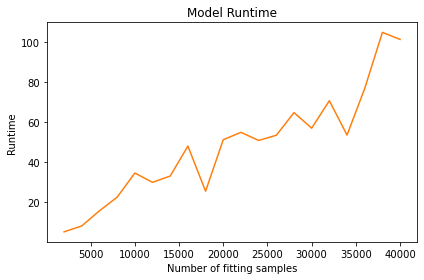

In [8]:
runtimes = data_N['times']
fig, ax = plt.subplots()
ax.plot(Ns, runtimes, color='tab:orange')
ax.set_ylabel('Runtime')
ax.set_xlabel('Number of fitting samples')
ax.set_title('Model Runtime')
fig.tight_layout()
plt.savefig('runtime_N_plot.png')
plt.show()

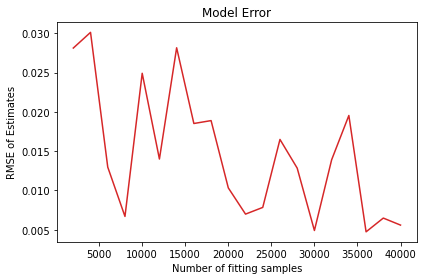

In [9]:
errors = data_N['errors']
fig, ax = plt.subplots()
ax.plot(Ns, errors, color='tab:red')
ax.set_ylabel('RMSE of Estimates')
ax.set_xlabel('Number of fitting samples')
ax.set_title('Model Error')
fig.tight_layout()
plt.savefig('error_N_plot.png')
plt.show()

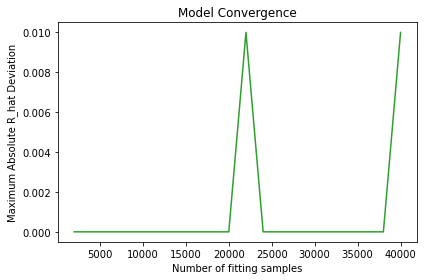

In [10]:
r_hats = data_N['r_hats']
fig, ax = plt.subplots()
ax.plot(Ns, r_hats, color='tab:green')
ax.set_ylabel('Maximum Absolute R_hat Deviation')
ax.set_xlabel('Number of fitting samples')
ax.set_title('Model Convergence')
fig.tight_layout()
plt.savefig('conv_N_plot.png')
plt.show()

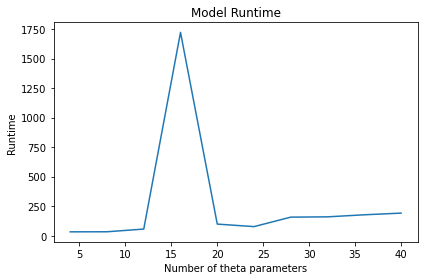

In [11]:
runtimes_P = data_P['times']
fig, ax = plt.subplots()
ax.plot(Ps, runtimes_P, color='tab:blue')
ax.set_ylabel('Runtime')
ax.set_xlabel('Number of theta parameters')
ax.set_title('Model Runtime')
fig.tight_layout()
plt.savefig('runtime_P_plot.png')
plt.show()

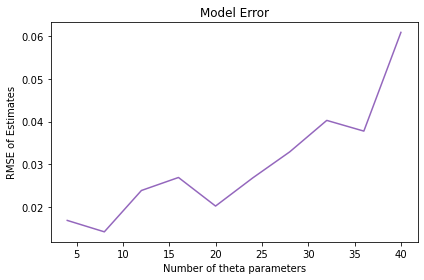

In [12]:
errors_P = data_P['errors']
fig, ax = plt.subplots()
ax.plot(Ps, errors_P, color='tab:purple')
ax.set_ylabel('RMSE of Estimates')
ax.set_xlabel('Number of theta parameters')
ax.set_title('Model Error')
fig.tight_layout()
plt.savefig('error_P_plot.png')
plt.show()

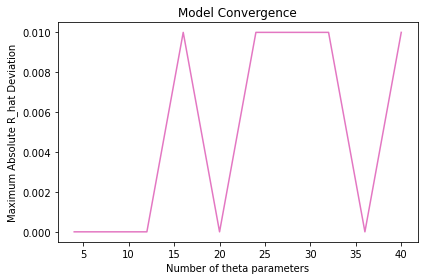

In [13]:
r_hats_P = data_P['r_hats']
fig, ax = plt.subplots()
ax.plot(Ps, r_hats_P, color='tab:pink')
ax.set_ylabel('Maximum Absolute R_hat Deviation')
ax.set_xlabel('Number of theta parameters')
ax.set_title('Model Convergence')
fig.tight_layout()
plt.savefig('conv_P_plot.png')
plt.show()